# Project Mona Lisa using dots

In [10]:
import numpy as np
from numpy import asarray
from PIL import Image as Img, ImageDraw
from matplotlib import image
from IPython.display import Image 
import time
import math
from multiprocessing import Pool
import pickle
import matplotlib.pyplot as plt
import os.path 

PNG
(685, 1024)
RGBA


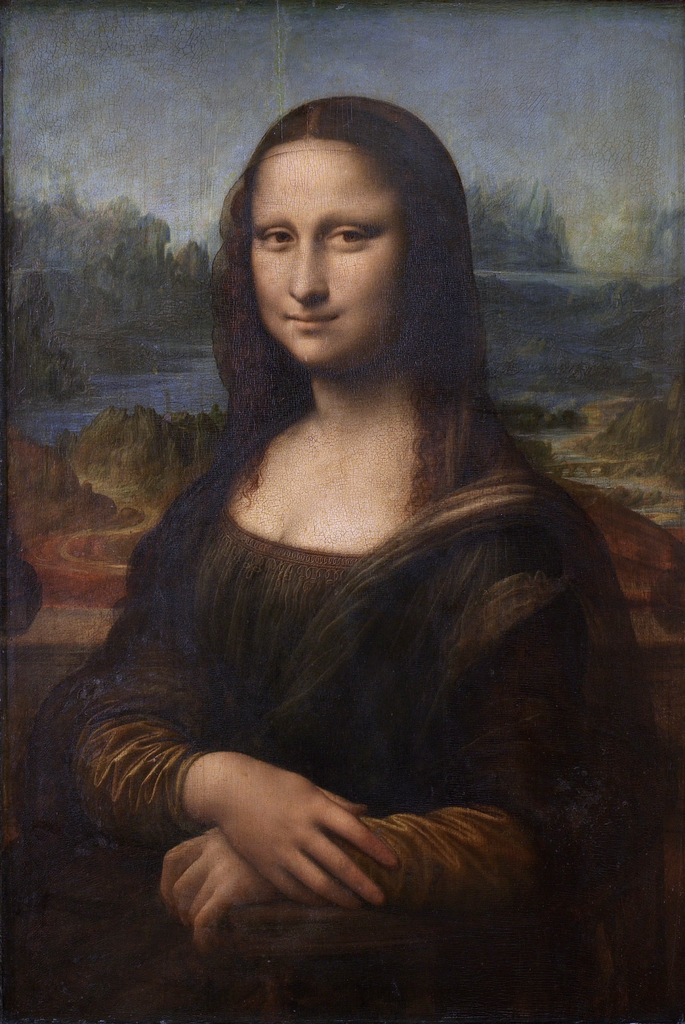

In [2]:
mona_lisa = Img.open("lisa_big.png")
print(mona_lisa.format)
print(mona_lisa.size)
print(mona_lisa.mode)
display(mona_lisa)

In [3]:
class ImageBuilder:
    def __init__(self, x_size=256, y_size=333, img_path=None):
        img_path = "lisa_big.png" if not img_path else img_path 
        img = Img.open(img_path).convert("RGBA").resize((x_size, y_size)) if img_path else None
        self.original = asarray(img)
        self.y, self.x, self.z = self.original.shape
        self.canvas = Img.new('RGBA', (img.size), (255,255,255,255))#(x_size, y_size), (255, 255, 255, 255))
        self.min_score = np.sum((self.original - np.array(self.canvas, dtype=np.int32)) ** 2) / (self.x * self.y)

    def show_original(self, x=None, y=None):
        img = Img.fromarray(np.array(self.original, dtype=np.uint8))
        if not x and not y:
            display(img)
        else:
            display(img.resize((x, y)))
        
    def show_canvas(self, x=None, y=None):
        img = Img.fromarray(np.array(self.canvas, dtype=np.uint8))
        if not x and not y:
            display(img)
        else:
            display(img.resize((x, y)))
    
    def draw_blended(blend):
        display(Img.fromarray(blend))
    
    def draw_circle(self, genom):
        box = genom.to_square(self.x, self.y)
        overlay = Img.new('RGBA', self.canvas.size, (0, 0, 0, 0))
        drw = ImageDraw.Draw(overlay, 'RGBA')
        drw.ellipse([box[0], box[1]], fill=tuple(genom.color), outline=None, width=1)
        blended = np.array(Img.alpha_composite(self.canvas, overlay), dtype=np.int32)
        del drw
        return blended

    def calculate_score(self, src):
        return (self.min_score.astype(int) - np.sum((self.original - src) ** 2) / (self.x * self.y)) / self.min_score.astype(int)

In [4]:
class Genome:
    def __init__(self, img_x=-1, img_y=-1, max_size=None, min_size=1):
        if img_x > 0:
            max_size = max_size if max_size else img_x // 3
            self.color = np.random.randint(low=0, high=255, size=(4), dtype=np.int32)
            self.position_x = np.random.randint(low=0, high=img_x)
            self.position_y = np.random.randint(low=0, high=img_y)
            self.radius = np.random.randint(low=min_size, high=max_size)
            self.img_x = img_x
            self.img_y = img_y
        else:
            self.color = np.array([0,0,0,0])
    def to_square(self, img_x, img_y):
        xy0 = (self.position_x - self.radius, self.position_y - self.radius)
        xy1 = (self.position_x + self.radius, self.position_y + self.radius)
        return xy0, xy1

    def from_vector(self, vec):
        self.position_x, self.position_y = vec[0], vec[1]
        self.radius = vec[2]
        self.color[0], self.color[1], self.color[2] = vec[3], vec[4], vec[5]
        self.color[3] = vec[6]
    
    def to_vector(self):
        return np.array([self.position_x, self.position_y, self.radius, self.color[0], self.color[1], self.color[2], self.color[3]])

In [12]:
def process_single(g):
    g,canvas = g
    obj = Genome()
    obj.from_vector(g)
    return canvas.calculate_score(canvas.draw_circle(obj))

def cost_fun(genomes, canvas, pool):
    return np.array([x for x in pool.imap(process_single, zip(genomes, [canvas] * len(genomes)))])

In [14]:
def es(canvas, objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1,  mn=0.0, mx=1.0, best=-np.inf, min_r=0, pool=None):
    if min_r < 0:
        min_r = 0
    domains = [canvas.x, canvas.y, canvas.y // 2, 255, 255, 255, 255]
    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = best
    current_population_solutions = np.zeros((population_size, chromosome_length), dtype=np.int32)
    for i, h in enumerate(domains):
        if i == 2:
            col = np.random.randint(h+1-min_r, size=(population_size)) + min_r
        else:
            col = np.random.randint(h+1, size=(population_size))
        current_population_solutions[:, i] = col

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions, canvas, pool)
    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length), dtype=np.int32)
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length), dtype=np.int32)
        res = []
        res_sig = []
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)
            
        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        
        cs = []
        csig = []
        
        for g,s in zip(children_population_solutions, children_population_sigmas):
            f = True
            for i, (k, d) in enumerate(zip(g, domains)):
                if i == 2:
                    if k < min_r or k > d:
                        f = False
                        break
                elif k < 0 or k > d:
                    f = False
                    break
            if f:
                cs.append(np.floor(g + 0.5))
                csig.append(s)
        children_population_solutions, children_population_sigmas = np.array(cs), np.array(csig)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions, canvas, pool)
        if len(cs) > 0:
            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
            current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]

        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]
        #print(best_solution)
        #if np.mod(t, log_frequency) == 0:
        #    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [7]:
def save_data(vector, name):
    serialized = pickle.dumps(vector, protocol=0)
    with open(name, 'wb') as f:
        f.write(serialized)
        
def load_data(name):
    with open(name, 'rb') as f:
        loaded = f.read()
    return pickle.loads(loaded)

def load_canvas(img_file, circles, x=None, y=None):
    x, y = (X, Y) if not x else (x, y)
    c = ImageBuilder(x, y, img_file)
    for circ in circles:
        obj = Genome()
        obj.from_vector(circ)
        meld = c.draw_circle(obj)
        c.canvas = Img.fromarray(np.array(meld, dtype=np.uint8))
    return c

In [13]:
def calculate_image(img_path, circle_target=1000, x=None, y=None, processes=3, save_name=None, force_load=None, set_min=False):
    d = 7
    N = 40
    T = 250
    m = 3 if set_min else 0
    save_name = img_path if not save_name else save_name
    x, y = (X, Y) if not x else (x, y)
    if os.path.isfile(save_name + ".cc"):
        circles = load_data(save_name + ".cc")
    else:
        circles = []
    if force_load:
        circles = load_data(force_load + ".cc")
    
    canvas = load_canvas(img_path, circles) if circles else ImageBuilder(x, y, img_path)
    last_score = -np.inf
    if os.path.isfile(save_name + ".hist"):
        best_hist = load_data(save_name + ".hist")
    else:    
        best_hist = []
    if force_load:
        best_hist = load_data(force_load + ".hist")
    pool = Pool(processes=processes)
    cons = 0
    while (circle_target - len(circles)) > 0:
        r = (x // 3) - ((len(circles) // 3) * 4) - cons
        if r < m:
            r = 0
        best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
            canvas, cost_fun, d, N, T, number_of_offspring=N, number_of_parents=1, sigma=20.0, tau=1/np.sqrt(2*d), tau_0=1/np.sqrt(2*np.sqrt(d)), log_frequency=1, min_r = r, pool=pool)#, best=last_score)
        if best_objective_value > last_score:
            last_score = best_objective_value
            obj = Genome()
            circles.append(best_chromosome)
            best_hist.append((history_objective_values, history_best_chromosome, history_best_sigmas))
            obj.from_vector(best_chromosome)
            meld = canvas.draw_circle(obj)
            canvas.canvas = Img.fromarray(np.array(meld, dtype=np.uint8))
            cons //= 2
            print(f"Circle nr: {len(circles)} added! score: {last_score}")
        else:
            cons += 1
        if len(circles) % 10 == 0:
            print("savepoint reached")
            save_data(circles, save_name + ".cc")
            save_data(best_hist, save_name + ".hist")
    return canvas, circles, best_hist

In [ ]:
# img_file = plik ze zdjęciem wzorcowym
# circle_taget = liczba kółek, po której dodaniu algorytm się zatrzyma
# x = wielość x, do której zostanie przeskalowany obraz wzorcowy
# y = wielkość y --||--
# processes = ilość procesów na któych ma się wyliczać ewaluacja populacji
# save_name = nazwa pliku, do którego jest serializowany vektor z dodanymi dotychczas kółkami oraz hisoria
# force_load = nazwa plików .cc i .hist z których zostaną załadowane poczatkowe wartości dla algorytmu i na którym będzie dalej ewoluować

X, Y = 342, 512
img_file = "lisa_big.png"
save_name = "mona_lisa_342x521_final2_2000"
c, cir, hist = calculate_image(img_file, 
                               circle_target=2000, 
                               x=X, 
                               y=Y, 
                               processes=3, 
                               save_name=save_name,
                               force_load="mona_lisa_342x521_final_1000")


In [32]:
def save_as_gif(img_name, circles, name, x=None, y=None):
    x, y = (X, Y) if not x else (x, y)
    c = ImageBuilder(x, y, img_name)
    def list_to_img(circ):
        obj = Genome()
        obj.from_vector(circ)
        meld = c.draw_circle(obj)
        c.canvas = Img.fromarray(np.array(meld, dtype=np.uint8))
        return c.canvas.copy()
    
    img, *imgs = [list_to_img(circles[j]) for j in range(0, len(circles))]
    img.save(fp=name, format='GIF', append_images=imgs, save_all=True, duration=20, loop=0)

##### Pierwsze podejście

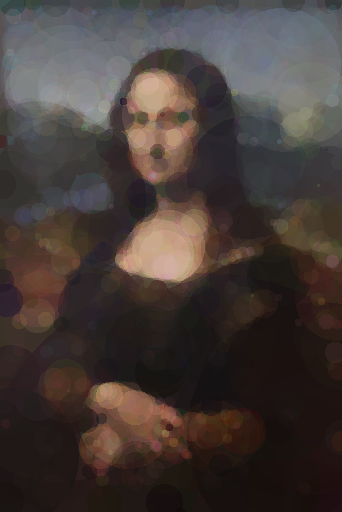

In [109]:
circ = load_data(f'mona_lisa_342x521_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

![SegmentLocal](mona_lisa_342x521_1000.gif "segment")


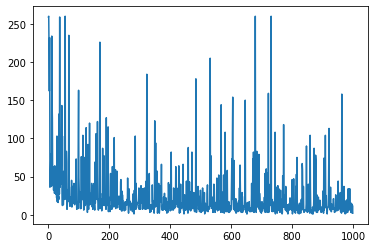

In [82]:
# wielkość kółek w czasie
plt.figure()
plt.plot(np.array(circ)[:, 2])
plt.show()

##### Drugie  podejście - minimalna wielkość kółek na start

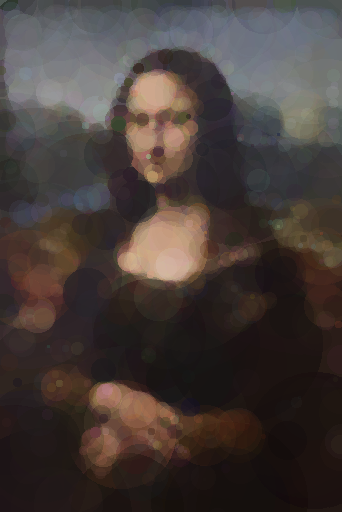

In [107]:
circ = load_data(f'mona_lisa_342x521_forced_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

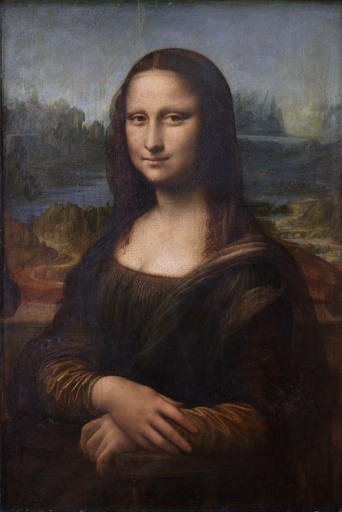

In [113]:
c.show_original()

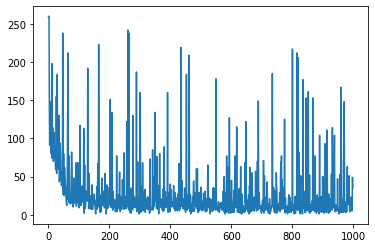

In [108]:
# wielkość kółek w czasie
plt.figure()
plt.plot(np.array(circ)[:, 2])
plt.show()

##### Podejście trzecie - trochę większe ograniczenie + minimalne kółko do przez wszystkie iteracje

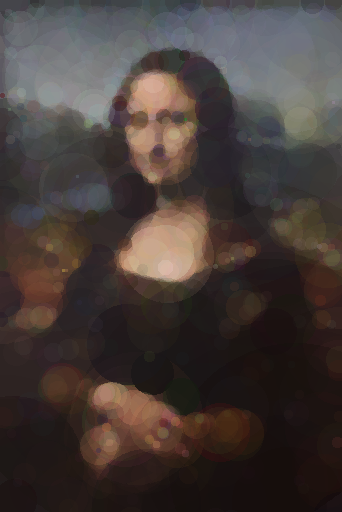

In [105]:
circ = load_data(f'mona_lisa_342x521_flex_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

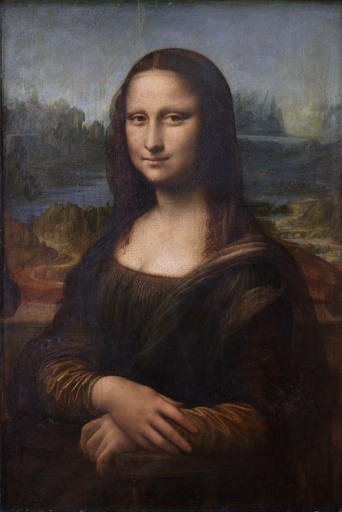

In [114]:
c.show_original()

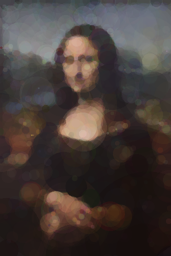

In [103]:
c.show_canvas(c.x // 2, c.y // 2)

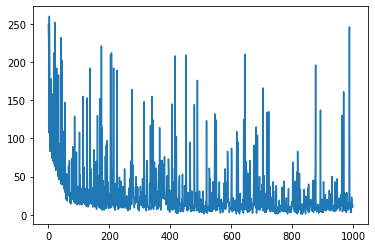

In [106]:
# wielkość kółek w czasie
plt.figure()
plt.plot(np.array(circ)[:, 2])
plt.show()

##### Podejście czwarte - dodatkowe punkty

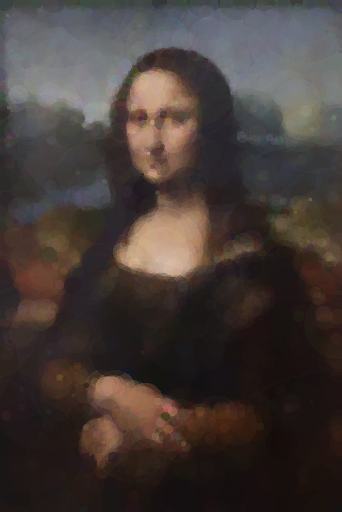

In [22]:
circ = load_data("mona_lisa_342x521_final2_2000.cc")
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

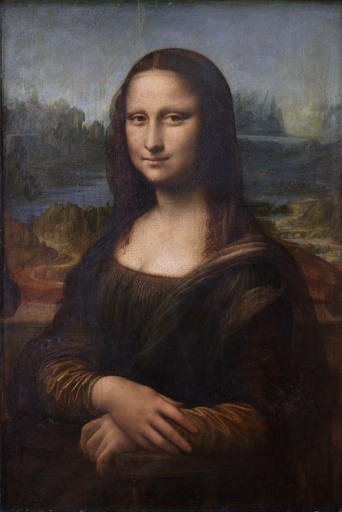

In [24]:
c.show_original()

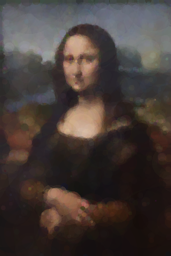

In [23]:
c.show_canvas(c.x // 2, c.y // 2)

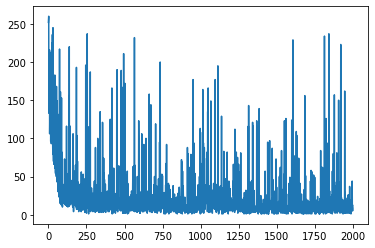

In [25]:
# wielkość kółek w czasie
plt.figure()
plt.plot(np.array(circ)[:, 2])
plt.show()

###### Inne przykłady 1

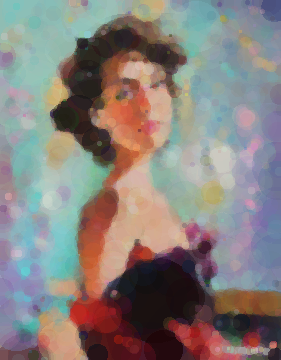

In [122]:
circ = load_data(f'obraz_342x521_forced_2000.cc')
c = load_canvas("obraz.jpg", circ, 281, 360)
c.show_canvas()

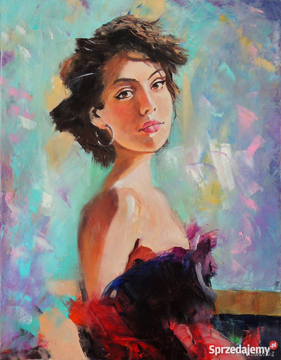

In [123]:
c.show_original()

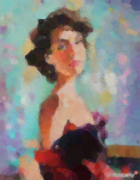

In [118]:
c.show_canvas(c.x // 2, c.y // 2)

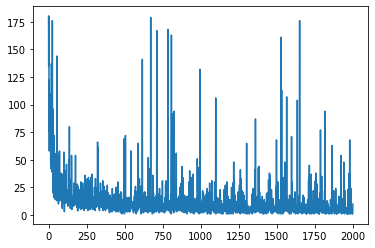

In [124]:
# wielkość kółek w czasie
plt.figure()
plt.plot(np.array(circ)[:, 2])
plt.show()

###### Inne przykłady 2

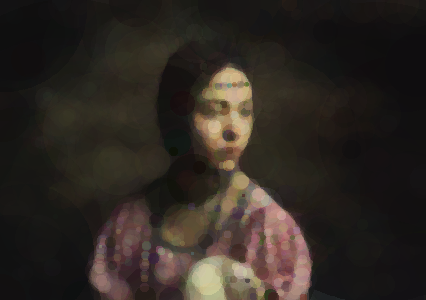

In [110]:
canvas.show_canvas()

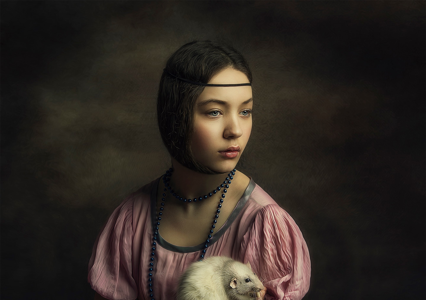

In [109]:
display(mona_lisa.resize((x,y)))

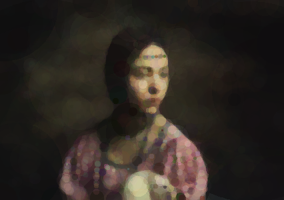

In [116]:
canvas.show_canvas(x // 3 * 2, y // 3 * 2)

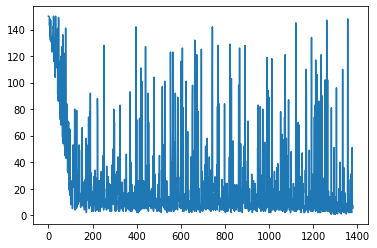

In [114]:
plt.figure()
plt.plot(np.array(circles)[:, 2])
plt.show()

## Algorithm analisis
**raw image:**

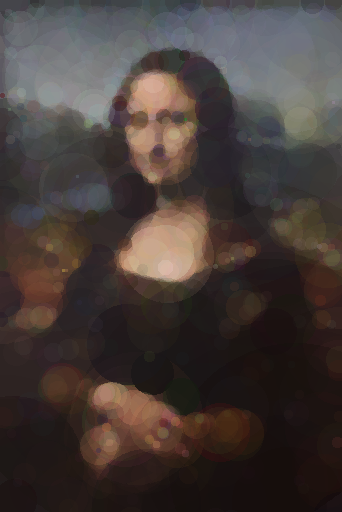

In [144]:
circ = load_data(f'mona_lisa_342x521_flex_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

Rozkład kółek na obrazie:

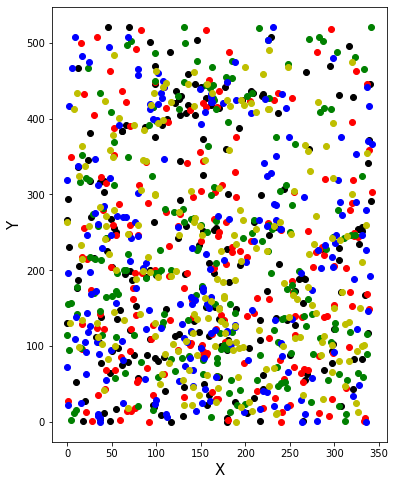

In [145]:
positionsX = np.array([x[0] for x in circ])
positionsY = np.array([x[1] for x in circ])

plt.figure(figsize=(6, 8))
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.plot(positionsX[0:200], positionsY[0:200], 'ko')
plt.plot(positionsX[200:400], positionsY[200:400], 'ro')
plt.plot(positionsX[400:600], positionsY[400:600], 'go')
plt.plot(positionsX[600:800], positionsY[600:800], 'bo')
plt.plot(positionsX[800:1000], positionsY[800:1000], 'yo')

plt.show()

Widać, że rozmieszczenie kółek na obrazie jest w miare równe. Kółka głównie koncentrują się w miejscach gdzie jest większa koncentracja różnych kolorów, kształtów (np. palce). Zatem poszczególne osobniki rzeczywiście próbują dopasować się do takich pozycji, gdzie zminimalizują funkcję kosztu.

##### Liczba kółek danej wielkości

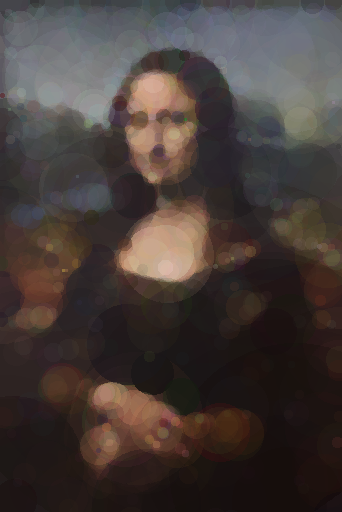

In [80]:
circ = load_data(f'mona_lisa_342x521_flex_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

In [81]:
sizes1 = [0 for _ in range(int(max(circ, key=lambda x: x[2])[2]+1))]
for cr in circ:
    r = int(cr[2])
    sizes1[r] += 1

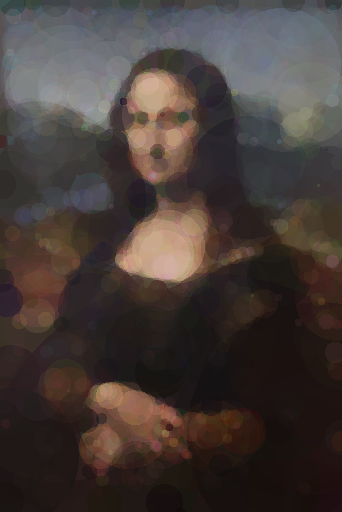

In [82]:
circ = load_data(f'mona_lisa_342x521_1000.cc')
c = load_canvas("lisa_big.png", circ)
c.show_canvas()

In [83]:
sizes2 = [0 for _ in range(int(max(circ, key=lambda x: x[2])[2]+1))]
for cr in circ:
    r = int(cr[2])
    sizes2[r] += 1

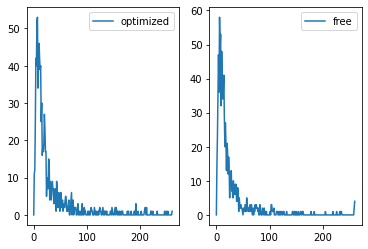

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sizes1, label='optimized')
ax2.plot(sizes2, label='free')
ax1.legend()
ax2.legend()

Widać, że w przypadku `zoptymalizowanej` wersji, gdzie wymuszamy z początku większe kółka jest nieco większa ilość kółek, które mają większe średnice niż w przypadku wersji bez restrykcji.

## Ruchy najlepszego kółka z w danej iteracji

In [21]:
circles = load_data('mona_lisa_342x521_final_1000.cc')
hist = load_data('mona_lisa_342x521_final_1000.hist')
x, y = 342, 521

In [162]:
def create_movement(generation_hist, i, circles, name):
    h = generation_hist[i][1]
    c = ImageBuilder(x, y)
    
    def add_to_canvas(circ):
        obj = Genome()
        obj.from_vector(circ)
        meld = c.draw_circle(obj)
        c.canvas = Img.fromarray(np.array(meld, dtype=np.uint8))
    
    _ = [add_to_canvas(circles[j]) for j in range(0, i)]
    imgs = []
    last = None
    for circ in h:
        if last is None:
            last = circ
        elif (last == circ).all():
            continue
        last = circ
        obj = Genome()
        obj.from_vector(circ)
        meld = c.draw_circle(obj)
        imgs.append(Img.fromarray(np.array(meld, dtype=np.uint8)))
    c.canvas.save(fp=name, format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)

Poniższe przykłady pokazują najlepsze osobniki ze wszystkich generacji w danej iteracji - widać, jak w kolejnych generacjach zminiają się najlepsi osobnicy.

In [169]:
create_movement(hist, 66, circles, "movement66.gif")

![SegmentLocal](movement66.gif "segment")


In [171]:
create_movement(hist, 67, circles, "movement67.gif")

![SegmentLocal](movement67.gif "segment")


In [164]:
create_movement(hist, 100, circles, "movement100.gif")

![SegmentLocal](movement100.gif "segment")


In [163]:
create_movement(hist, 200, circles, "movement200.gif")

![SegmentLocal](movement200.gif "segment")


In [70]:
create_movement(hist, 600, circles, "movement600.gif")

![SegmentLocal](movement600.gif "segment")


Widać, jak kółka dopasowują się do funkcji kosztu. Pokazałem głównie przykłady kiedy liczba kółek jest mniejsza, bo wtedy minimalny radius jest większy dzięki temu lepiej widać ewoluowanie punktów

###### Średnia $\sigma$ w kolejnych kółkach

In [172]:
circles = load_data('mona_lisa_342x521_final_1000.cc')
hist = load_data('mona_lisa_342x521_final_1000.hist')
x, y = 342, 521

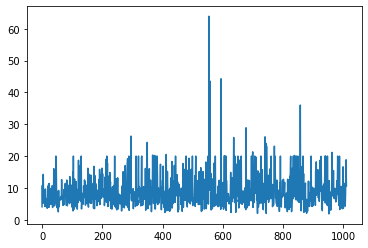

In [180]:
sigmas = [sig[-1] for sig in hist]
sigmas = [np.median(sig[sig != 0]) for sig in sigmas]

plt.figure()
plt.plot(np.array(sigmas))
plt.show()

Nic ciekawego nie można wywnioskować poza tym, że sigmy były w miarę równo rozłożone w kolejnych iteracjach, zatem startowa $\sigma = 20$ okazuje się być trafiona.

#### Liczba iteracji po której $\sigma = 0$

In [183]:
circles = load_data('mona_lisa_342x521_final_1000.cc')
hist = load_data('mona_lisa_342x521_final_1000.hist')
x, y = 342, 521

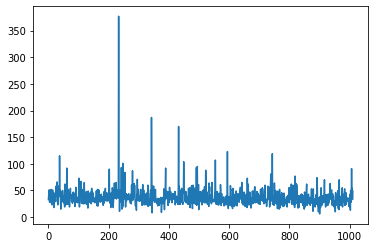

In [187]:
sigmas = [sig[-1] for sig in hist]
res = []
for s in sigmas:
    cnt = 0
    for v in s:
        if (v == 0.0).all():
            break
        cnt += 1
    res.append(cnt)

plt.figure()
plt.plot(np.array(res))
plt.show()

W tym przypadku liczba iteracji na kółko wynosiła 400. Widać, że można obniżyć nieco liczbę iteracji - maksymalnie osobnik liczył się przez 350, po czy sigma się zeruje więc reszta iteracji jest bezsensowna